In [11]:
from pydantic import BaseModel
from random import randint, choice, uniform
from tqdm import tqdm
import pandas as pd

MAX_WEIGHT = 1500
MAX_STATES = 10000
BAG_SIZE = 30
PENALIZATION = 100

class Item(BaseModel):
    value: int
    weight: int
    state: bool = False


class Bag(BaseModel):
    items: list[Item]
    score: int = 0
    total_values: int = 0
    total_weight: int = 0
    percentage: float = 0

    def __init__(self, **data):
        super().__init__(**data)
        self.calculate_totals()

    def calculate_totals(self):
        self.total_values = sum(item.value for item in self.items if item.state)
        self.total_weight = sum(item.weight for item in self.items if item.state)

        if self.total_weight > MAX_WEIGHT:
            self.score = (
                self.total_values - (self.total_weight - MAX_WEIGHT) - PENALIZATION
            )
        else:
            self.score = self.total_values 


def generate_item() -> Item:
    return Item(
        value=randint(1, 100),
        weight=randint(1, 200),
        state=False
    )


def is_valid_state(bag: list[Item]) -> bool:
    weights = [item.weight for item in bag if item.state]
    total_weight = sum(weights)

    if total_weight > MAX_WEIGHT:
        return False

    return True


def generate_items() -> list[Item]:
    return [generate_item() for _ in range(BAG_SIZE)]


def generate_initial_bag(original_items: list[Item]) -> Bag:
    items = [
        Item(value=item.value, weight=item.weight, state=choice([True, False]))
        for item in original_items
    ]
    return Bag(items=items)

## População inicial

In [12]:
import copy

def create_initial_populations():
    items = generate_items()
    initial_population = [generate_initial_bag(items) for _ in range(30)]
    copy_initial_population = copy.copy(initial_population)

    return initial_population, copy_initial_population

## Adaptação

In [13]:
def adapt_function(initial_population: list[Bag]) -> list[Bag]:
    total_score = sum(bag.score for bag in initial_population)

    for bag in initial_population:
        bag.calculate_totals()
        bag.percentage = (bag.score / total_score) * 100

    initial_population.sort(key=lambda bag: bag.score)

    # for bag in initial_population:
    #     print(
    #         f"Score: {bag.score} | Peso: {bag.total_weight} | Valor: {bag.total_values} | Porcentagem: {bag.percentage:.2f}%"
    #     )

    return initial_population

## Seleção

In [14]:
from random import choices

def selection_function(initial_population: list[Bag]) -> list[Bag]:
    scores = [bag.score for bag in initial_population]
    bags = [bag for bag in initial_population]

    selected_bags = []

    while len(selected_bags) < 30:
        selected_bag = choices(bags, weights=[bag.percentage for bag in bags], k=1)[0]
        
        if selected_bags.count(selected_bag) < 2:
            selected_bags.append(selected_bag)    

    return selected_bags

## Crossover

In [15]:
import random
import pandas as pd
import copy

def crossover(bag_a: Bag, bag_b: Bag, first_cross_point: int, second_cross_point: int) -> tuple[Bag, Bag]:
    new_bag_a = copy.deepcopy(bag_a)

    new_bag_a.items[first_cross_point: second_cross_point] = bag_b.items[first_cross_point: second_cross_point]

    bag_b.items[first_cross_point: second_cross_point] = bag_a.items[first_cross_point: second_cross_point]

    return new_bag_a, bag_b


def generate_crossover_bags(selected_bags: list[Bag]) -> list[Bag]:
    crossoved_bags = []

    for idx in range(0, 30, 2):
        cross_a = selected_bags[idx]
        cross_b = selected_bags[idx + 1]


        first_cross_point = random.randint(1, 14)
        second_cross_point = random.randint(16, 29)

        cross_a, cross_b = crossover(cross_a, cross_b, first_cross_point, second_cross_point)

        crossoved_bags.append(cross_a)
        crossoved_bags.append(cross_b)
    
    return crossoved_bags



## Mutação

In [16]:
import random

MUTATION = random.randint(1, 10)


def mutation_function(bags: list[Bag]) -> list[Bag]:
    bags_for_mutation = choices(bags, weights=[bag.percentage for bag in bags], k=MUTATION)
    total_score = sum(bag.score for bag in bags)

    for bag in bags:
        if bag in bags_for_mutation:
            MUTATION_ITEM = random.randint(0, 29)    
            bag.items[MUTATION_ITEM].state = not bag.items[MUTATION_ITEM].state
        bag.calculate_totals()
        bag.percentage = (bag.score / total_score) * 100

    return bags

## Algoritmo Completo

In [17]:
from tqdm import tqdm
original_population, copy_population = create_initial_populations()

for i in tqdm(range(10_000)):
    copy_population = adapt_function(copy_population)
    copy_population = selection_function(copy_population)
    copy_population = generate_crossover_bags(copy_population)
    copy_population = mutation_function(copy_population)

100%|██████████| 10000/10000 [01:32<00:00, 107.91it/s]


In [38]:
original_population.sort(key=lambda bag: bag.score)

data = {
    "score": [bag.score for bag in original_population],
    "weight": [bag.total_weight for bag in original_population],
    "values": [bag.total_values for bag in original_population],
    "percentage": [bag.percentage for bag in original_population],
}

# for bag in original_population:
# print(
#     f"Score: {bag.score} | Peso: {bag.total_weight} | Valor: {bag.total_values} | Porcentagem: {bag.percentage:.2f}%"
# )

no_mutation = pd.DataFrame(data)
no_mutation.head(30)

,score,weight,values,percentage
0,433,1720,753,2.236224
1,475,1828,903,2.453132
2,491,1102,491,2.535764
3,546,905,546,2.819811
4,564,1007,564,2.912772
5,590,1404,590,2.638994
6,598,1567,765,3.088364
7,604,1897,1101,3.014423
8,614,1670,884,3.170996
9,622,1015,622,3.104257


In [39]:
copy_population.sort(key=lambda bag: bag.score)

data = {
    "score": [bag.score for bag in copy_population],
    "weight": [bag.total_weight for bag in copy_population],
    "values": [bag.total_values for bag in copy_population],
    "percentage": [bag.percentage for bag in copy_population]
}

# for bag in copy_population:
#     print(
#         f"Score: {bag.score} | Peso: {bag.total_weight} | Valor: {bag.total_values} | Porcentagem: {bag.percentage:.2f}%"
#     )

genetic_results = pd.DataFrame(data)
genetic_results.head(30)

,score,weight,values,percentage
0,714,1649,963,2.770556
1,714,1649,963,2.770556
2,727,1059,727,2.821000
3,770,1116,770,2.987855
4,779,1310,779,3.022778
5,782,1078,782,3.034419
6,797,1622,1019,3.092623
7,808,1682,1090,3.135307
8,825,1116,825,3.201273
9,827,1134,827,3.209033


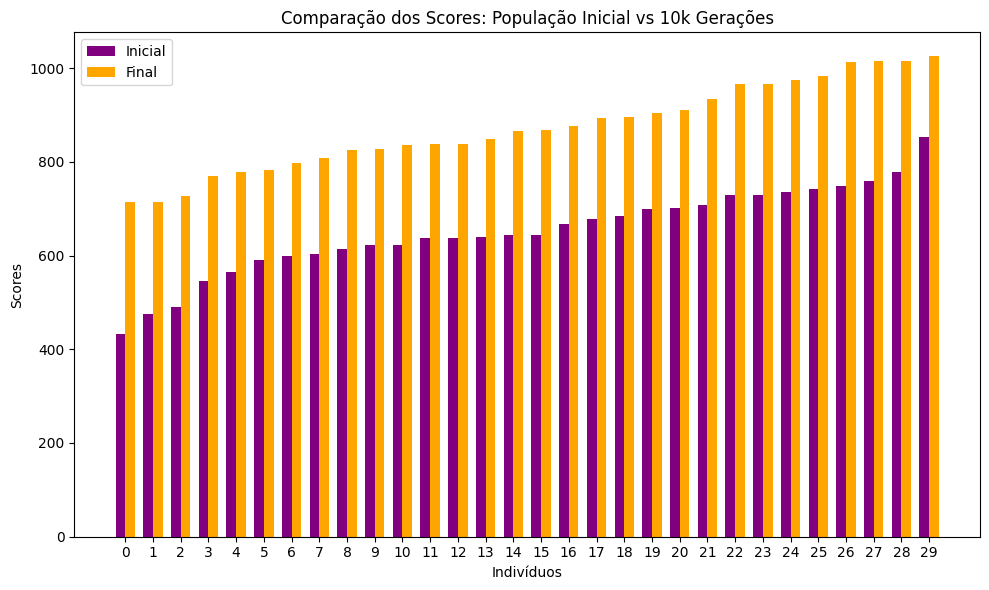

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = range(30) 

initial_scores = no_mutation["score"]
final_scores = genetic_results["score"]

initial_weights = no_mutation["weight"]
final_weights = genetic_results["weight"]
initial_values = no_mutation["values"]
final_values = genetic_results["values"]
initial_percentage = no_mutation["percentage"]
final_percentage = genetic_results["percentage"]

width = 0.35  # Largura das barras

x = np.arange(len(labels))

plt.figure(figsize=(14, 8))
plt.bar(x - width / 2, initial_scores, width, label="Inicial", color="purple")
plt.bar(x + width / 2, final_scores, width, label="Final", color="orange")

plt.xlabel("Indivíduos")
plt.ylabel("Scores")
plt.title("Comparação dos Scores: População Inicial vs 10k Gerações")
plt.xticks(x, labels)
plt.legend()

# 5. Exibir o gráfico
plt.tight_layout()
plt.show()